In this project, you'll be working with traffic video feed data from Dhaka, Bangladesh. The goal is to take each frame of video and detect and label objects such as cars and people in real-time. You'll use both a pre-trained model but extend an existing model to detect custom objects for the task of analyzing traffic feed data.

Some of the things you'll learn are:

- How to work with XML data that have bounding box data
- How to extract frames from video files
- How to apply the pretrained YOLO object detection model
- How to train YOLO to extend it to detect custom objects
- How to augment data to enhance a model's ability to generalize when training

# Part 1: Object Detection

### Getting Ready

In [44]:
import sys
from pathlib import Path
from collections import Counter
import xml.etree.ElementTree as ET

from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import torch
import PIL
from pytube import YouTube
import matplotlib.pyplot as plt

### Exploring the data
Here we will use the [Dhaka AI dataset](https://www.kaggle.com/datasets/rifat963/dhakaai-dhaka-based-traffic-detection-dataset). It contains images of vehicles in urban traffic scens from Ghaka, Bangladesh. It will be used for object detection. Object detection includes 
1. identifying specific objects within an image(cars, buses, bikes),
2. determining the precise location of these objects, and
3. drawing a bounding box around each detected object.

In [3]:
train_dir = Path("../data/Dhaka AI dataset/train", "Final Train Dataset")
print("Train data directory:", train_dir)

Train data directory: ..\data\Dhaka AI dataset\train\Final Train Dataset


Let's see some of the training data.

In [7]:
train_data = list(train_dir.iterdir())
train_data[:8]

[WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/01.jpg'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/01.xml'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/02.jpg'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/02.xml'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/03.jpg'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/03.xml'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/04.jpg'),
 WindowsPath('../data/Dhaka AI dataset/train/Final Train Dataset/04.xml')]

As can be seen above, the training data contains two types of files, `.jpg` files which are the actual image files, and `.xml` files which contain the annotations for the images. And also each image typically has a corresponding XML file.

Are there other file types in the directory?

In [8]:
ext_counts = Counter(Path(file).suffix for file in train_data)

In [11]:
for ext, count in ext_counts.items():
    print(f"'{ext}' file type files: {count}")

'.jpg' file type files: 2844
'.xml' file type files: 3003
'.jpeg' file type files: 2
'.png' file type files: 12
'.JPG' file type files: 143
'.PNG' file type files: 2


### Separating images and annotations

The annotations (`.xml` files) contain all information about each image, including folder, path, bounding box, etc. Bounding boxes are rectangles around detected objects. Let's separate the images and from the `.xml` files. Then we will move the files to there respective folder. Finally the size of the two folders will be checked.

In [12]:
img_dir = train_dir / "Images"
annt_dir = train_dir / "Annotations"

img_dir.mkdir(exist_ok= True)
annt_dir.mkdir(exist_ok= True)

In [13]:
for file in train_data:
    if file.suffix.lower() == ".xml":
        file.rename(annt_dir / file.name)
    elif file.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        file.rename(img_dir / file.name)

In [14]:
img_files = list(img_dir.iterdir())
annt_files = list(annt_dir.iterdir())

assert len(img_files) == len(annt_files)

print(f"Images= {len(img_files)}")
print(f"Annotations= {len(annt_files)}")

Images= 3003
Annotations= 3003


### Annotations

The annotations are the labels for the data. Each image has an annotation which contains the coordinates and types of object for each bounding box in a given image. Let's see at the structure of the annotation by loading the first 37 lines of the files. The annotations are stored as `XML` which is a way to store structured documents.

In [15]:
xml_filepath = annt_dir / "01.xml"
!head -n 25 %xml_filepath

'head' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
with xml_filepath.open("r", encoding= "utf-8") as f:
    for i, line in enumerate(f):
        if i > 36: # i starts from 0
            break
        print(line.rstrip())

<annotation>
	<folder>Images</folder>
	<filename>02_Motijheel_280714_0005.jpg</filename>
	<path>E:\Datasets\Dataset\Images\02_Motijheel_280714_0005.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1200</width>
		<height>800</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bus</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>833</xmin>
			<ymin>390</ymin>
			<xmax>1087</xmax>
			<ymax>800</ymax>
		</bndbox>
	</object>
	<object>
		<name>bus</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>901</xmin>
			<ymin>284</ymin>
			<xmax>1018</xmax>
			<ymax>395</ymax>
		</bndbox>
	</object>


The above example shows that the annotation contains different tags such as folder, filename, path, etc. What we want to see and use is the `object` tag. It describes the object detected in the image. Under the object tag, a bounding box "bndbox" is given. It is a rectangular outline that marks the location of an object within an image. It’s commonly used in computer vision tasks like object detection, where models need to know where an object is and what it is. The bounding box has the following four tags:

* `xmin` → X-coordinate of the top-left corner of the box
* `ymin` → Y-coordinate of the top-left corner of the box
* `xmax` → X-coordinate of the bottom-right corner of the box
* `ymax` → Y-coordinate of the bottom-right corner of the box

The `ElementTree (ET)` module in Python can parse an XML file. The root is the top-level element that contains all other elements. The `tag` attribute contains the name of the element.

In [23]:
tree = ET.parse(xml_filepath)
root = tree.getroot()
print(root.tag)

annotation


The `find` method is used to locate the first occurrence of a sub-element with a given tag.

The `findall` method finds all occurrences of a sub-element within a given tag.

In [24]:
width = int(root.find("size").find("width").text)
height = int(root.find("size").find("height").text)

print(f"Image width: {width}, Image height: {height}")

Image width: 1200, Image height: 800


In [25]:
bndboxes = []
obj_names = []
for obj in root.findall("object"):
    name = obj.find("name").text
    obj_names.append(name)
    xmin = int(obj.find("bndbox").find("xmin").text)
    ymin = int(obj.find("bndbox").find("ymin").text)
    xmax = int(obj.find("bndbox").find("xmax").text)
    ymax = int(obj.find("bndbox").find("ymax").text)
    bndboxes.append([xmin, ymin, xmax, ymax])

for name, bndbox in zip(obj_names, bndboxes):
    print(f"{name}: {bndbox}")

bus: [833, 390, 1087, 800]
bus: [901, 284, 1018, 395]
bus: [909, 241, 1010, 287]
rickshaw: [761, 413, 832, 540]
rickshaw: [777, 364, 828, 409]
rickshaw: [120, 351, 177, 423]
rickshaw: [178, 340, 245, 419]
rickshaw: [551, 229, 581, 267]
rickshaw: [849, 211, 870, 240]
rickshaw: [854, 191, 872, 208]
rickshaw: [395, 250, 437, 286]
rickshaw: [626, 209, 653, 240]
motorbike: [863, 241, 882, 268]
car: [218, 252, 289, 285]
car: [495, 216, 531, 244]
car: [485, 201, 520, 219]
three wheelers (CNG): [254, 347, 298, 418]
three wheelers (CNG): [398, 307, 457, 353]
three wheelers (CNG): [240, 290, 303, 344]
pickup: [933, 176, 959, 197]
three wheelers (CNG): [709, 188, 728, 207]
minivan: [575, 213, 600, 244]
car: [530, 212, 549, 237]
minivan: [592, 187, 633, 197]
suv: [616, 198, 654, 212]
suv: [879, 161, 918, 179]
minivan: [850, 151, 882, 166]
rickshaw: [844, 191, 856, 211]
van: [827, 174, 852, 194]
pickup: [410, 226, 452, 252]


Now what is the image looks like?

(-0.5, 1199.5, 799.5, -0.5)

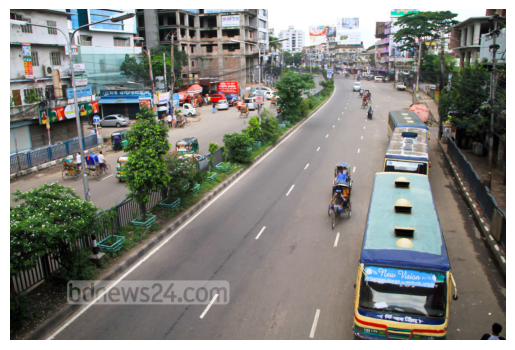

In [36]:
img_samp = img_dir / "01.jpg"
image = PIL.Image.open(img_samp)
plt.imshow(image)
plt.axis("off")

### Bounding boxes in PyTorch

First the bounding boxes will be converted to PyTorch tensors. Then those tensors will be used to add bounding boxes and labels to the image.

In [34]:
bndbox_tensors = torch.Tensor(bndboxes)
print(bndbox_tensors)

tensor([[ 833.,  390., 1087.,  800.],
        [ 901.,  284., 1018.,  395.],
        [ 909.,  241., 1010.,  287.],
        [ 761.,  413.,  832.,  540.],
        [ 777.,  364.,  828.,  409.],
        [ 120.,  351.,  177.,  423.],
        [ 178.,  340.,  245.,  419.],
        [ 551.,  229.,  581.,  267.],
        [ 849.,  211.,  870.,  240.],
        [ 854.,  191.,  872.,  208.],
        [ 395.,  250.,  437.,  286.],
        [ 626.,  209.,  653.,  240.],
        [ 863.,  241.,  882.,  268.],
        [ 218.,  252.,  289.,  285.],
        [ 495.,  216.,  531.,  244.],
        [ 485.,  201.,  520.,  219.],
        [ 254.,  347.,  298.,  418.],
        [ 398.,  307.,  457.,  353.],
        [ 240.,  290.,  303.,  344.],
        [ 933.,  176.,  959.,  197.],
        [ 709.,  188.,  728.,  207.],
        [ 575.,  213.,  600.,  244.],
        [ 530.,  212.,  549.,  237.],
        [ 592.,  187.,  633.,  197.],
        [ 616.,  198.,  654.,  212.],
        [ 879.,  161.,  918.,  179.],
        [ 85

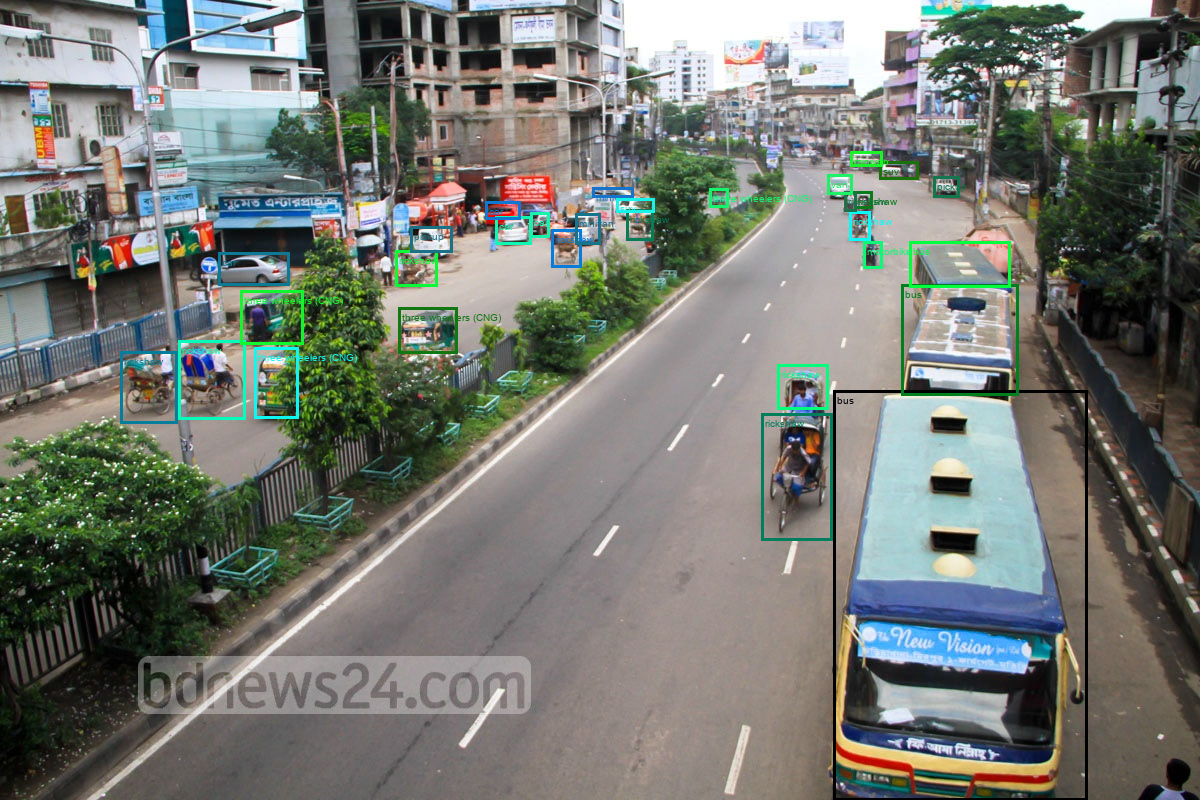

In [37]:
img = read_image(str(img_samp))

img = draw_bounding_boxes(
    image= img,
    boxes= bndbox_tensors,
    labels= obj_names,
    width= 3,
    fill= False,
    font= "arial.ttf",
    font_size= 10,
)

to_pil_image(img)

### YouTube Video Data
Now, let's download and load a YouTube video of traffic in Dhaka, Bangladesh.

In [41]:
vid_dir = train_dir / "video" 
vid_name = "dhaka_traffic.mp4"
print(vid_dir)

..\data\Dhaka AI dataset\train\Final Train Dataset\video


In [50]:
# Download YouTube video robustly with pytube and fallback to yt-dlp
import shutil
import subprocess
from urllib.error import HTTPError

# Use video id only (safer than timestamps/extra params)
url = "https://www.youtube.com/watch?v=0B2-cR4GEjc"
try:
    yt = YouTube(url)
    try:
        stream = yt.streams.get_highest_resolution()
    except HTTPError as e:
        print("HTTPError (get_highest_resolution):", e)
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if stream:
        vid_dir.mkdir(parents=True, exist_ok=True)
        print("Downloading with pytube:", stream)
        stream.download(output_path=str(vid_dir), filename=vid_name)
    else:
        raise RuntimeError("No suitable stream found with pytube")
except Exception as e:
    print("pytube failed or video not accessible via pytube:", e)
    # fallback to yt-dlp
    if shutil.which("yt-dlp") is None:
        print("Installing yt-dlp...")
        subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", "yt-dlp"], check=True)
    out_path = str(vid_dir / vid_name)
    print("Downloading with yt-dlp to", out_path)
    subprocess.run(["yt-dlp", "-f", "best", "-o", out_path, url], check=True)

HTTPError (get_highest_resolution): HTTP Error 400: Bad Request
pytube failed or video not accessible via pytube: HTTP Error 400: Bad Request
Installing yt-dlp...


In [46]:
# Show video info if available
try:
    if 'yt' not in globals():
        yt = YouTube(url)
    print(yt.watch_url, yt.video_id, yt.title)
except Exception as e:
    print("Could not create YouTube object to fetch metadata:", e)

HTTPError: HTTP Error 400: Bad Request

In [48]:
# safer: pass only the video id
yt = YouTube("https://www.youtube.com/watch?v=0B2-cR4GEjc")